# How to run jobs on quantum hardware
**Running jobs on quantum hardware using Fire Opal**

Fire Opal provides a suite of functions for submitting jobs to quantum hardware or simulators, enabling efficient and optimized execution of quantum algorithms. This guide introduces and demonstrates five core functions for job submission: `execute`, `iterate`, `estimate_expectation`, `iterate_expectation` and `solve_qaoa`. Each function is tailored to the following use cases, allowing you to maximize the potential of your quantum resources:
- `execute` is designed for a single circuit or a single list of circuits
- `estimate_expectation` is a variant of `execute` that estimates the expectation value of an executed circuit from a given set of observables
- `iterate` is optimized for multi-job workloads
- `iterate_expectation` is a variant of `iterate` that estimates the expectation value of an executed circuit from a given set of observables for multi-job workloads
- `solve_qaoa` runs a hybrid quantum-classical workload and submits the hardware jobs required to reach an answer

## 1. Imports and initialization
To run these examples, you'll first need to set up your account information for Fire Opal and your hardware provider.

In [ ]:
# Import necessary packages
import fireopal as fo
from qiskit import QuantumCircuit, qasm3
from qiskit.circuit import Parameter
import numpy as np
import networkx as nx

In [ ]:
# Replace "YOUR_QCTRL_API_KEY" with your API key, which you can find at https://accounts.q-ctrl.com/security
api_key = "YOUR_QCTRL_API_KEY"
fo.authenticate_qctrl_account(api_key=api_key)

# Insert your token and instance information
ibm_token = "YOUR_IBMQ_TOKEN"
hub = "ibm-q"
group = "open"
project = "main"

# Create your credentials dictionary hardware platform authentication
credentials = fo.credentials.make_credentials_for_ibmq(
    token=ibm_token, hub=hub, group=group, project=project
)

Q-CTRL authentication successful!


## 2. Running a single job in Fire Opal

### 2.1 Submitting a circuit with `execute`
The `execute` function is designed for direct execution of a single circuit or a single list of circuits. It applies Fire Opal’s error suppression pipeline to the circuits before submitting them to the specified quantum backend.

The following [entanglement](https://www.youtube.com/watch?v=JotTK1QoKUU) circuit demonstrates a basic example of how to code and run a job using the execute function. For a more in depth example of benchmarking a Bernstein–Vazirani with the `execute` function, see the [Get started](https://docs.q-ctrl.com/fire-opal/discover/start-using/get-started) guide.

#### 2.1.1 Create the circuit

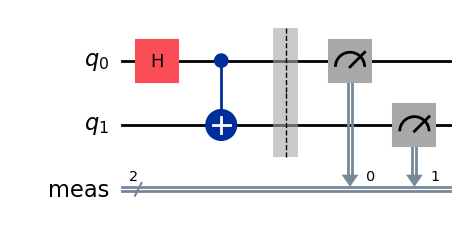

In [3]:
# Create a basic circuit with a Hadamard and a CNOT gate
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.measure_all()
qc.draw("mpl")

#### 2.1.2 Submit the job
Be sure to [choose a backend](https://docs.quantum.ibm.com/guides/get-qpu-information) and replace `"desired_backend"` with the target name.

In [ ]:
# Define shots and desired backend (replace "desired_backend" with your backend)
shot_count = 1024
backend_name = "desired_backend"

In [ ]:
# Run the circuit with the execute function
fire_opal_job = fo.execute(
    circuits=[qasm3.dumps(qc)],
    shot_count=shot_count,
    credentials=credentials,
    backend_name=backend_name,
)

#### 2.1.3 Check status and retrieve result

In [ ]:
# Check status
fire_opal_job.status()

The following function retrieves results or, if an error occurred, the corresponding error messages. The results contain the bitstring counts and the ID of the job submitted to the hardware provider.

You may also receive warnings if the device quality is degraded or experiencing significant fluctuations.

In [15]:
fire_opal_job.result()

{'results': [{'00': 0.5075728297233582, '11': 0.49242717027664185}],
 'provider_job_id': 'cy5de00rta1g00871x5g'}

### 2.2 Submitting a circuit with `estimate_expectation`
The `estimate_expectation` function is designed to execute a single circuit or a single list of circuits and compute the expectation values of a given set of observables. Like `execute`, it also applies Fire Opal’s error suppression pipeline to the circuits before submitting them to the specified quantum backend.

The following code demonstrates a basic example of how to run a job using the `estimate_expectation` function. It prepares a circuit in a $|\Psi^+\rangle$ Bell state and estimates the expectation values of the $Z_0 \otimes Z_1$ and $X_0 \otimes X_1$ observables.

#### 2.2.1 Create the circuit

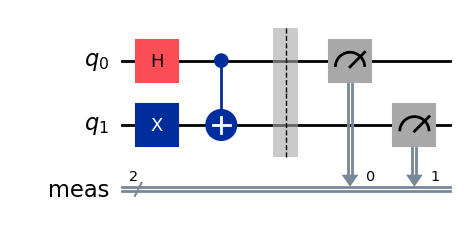

In [4]:
# Create a basic circuit with a Hadamard and a CNOT gate
qc = QuantumCircuit(2)
qc.h(0)
qc.x(1)
qc.cx(0, 1)
qc.measure_all()
qc.draw("mpl")

#### 2.2.2 Create the observables
The `estimate_expectation` function requires a list of observables to estimate the expectation values of this circuit. You can build these observables using a list of Pauli strings.

In [5]:
observables = ["ZZ", "XX"]

#### 2.2.3 Submit the `estimate_expectation` job
Just like in `execute`, you choose a backend and replace `"desired_backend"` with the target name. A relatively high `shot_count` should be used to ensure the best accuracy of the expectation value estimation.

In [ ]:
# Define shots and desired backend (replace "desired_backend" with your backend)
shot_count = 1024
backend_name = "desired_backend"

In [7]:
# Run the circuit with the estimate_expectation function
fire_opal_job = fo.estimate_expectation(
    circuits=[qasm3.dumps(qc)],
    shot_count=shot_count,
    credentials=credentials,
    backend_name=backend_name,
    observables=observables,
)

#### 2.2.4 Check status and retrieve result

In [8]:
# Check status
fire_opal_job.status()

{'status_message': 'Job has been submitted to Q-CTRL.',
 'action_status': 'STARTED'}

You will receive the expectation values and standard deviations corresponding to the list of observables defined above.

In [9]:
fire_opal_job.result()

{'provider_job_id': 'cz19thjkvm9g008fp1j0',
 'expectation_values': [-0.9921875, 0.990234375],
 'standard_deviations': [0.12475562048961962, 0.13941263417767907]}

## 3. Running multiple jobs in Fire Opal

### 3.1 Submitting a circuit with `iterate`
The iterate function is optimized for use cases where you must submit multiple jobs, which generally fall into two categories: [variational algorithms and batch workloads](https://docs.q-ctrl.com/fire-opal/execute/submit-jobs/iterative-and-batch-workloads).

The following code demonstrates a basic example of using iterate to submit multiple jobs. You can also refer to more in depth guides on using `iterate` to run [batch workloads](https://docs.q-ctrl.com/fire-opal/execute/submit-jobs/how-to-run-batch-workloads) and [variational algorithms](https://docs.q-ctrl.com/fire-opal/execute/run-algorithms/how-to-run-custom-variational-algorithms).

#### 3.1.1 Create the circuit
Workloads that require multiple job submissions often leverage parameterized circuits, where the same circuit is executed with different parameter values. However, you can also use `iterate` to run non-parameterized circuits.

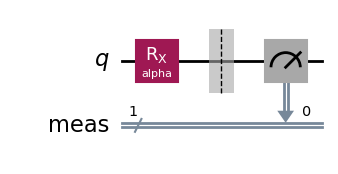

In [3]:
from qiskit.circuit import Parameter

angle = Parameter("alpha")  # undefined number

# Create and optimize circuit once
param_qc = QuantumCircuit(1)
param_qc.rx(angle, 0)
param_qc.measure_all()
param_qc.draw("mpl")

#### 3.1.2 (Optional) Generate random parameters

In [4]:
# Generate sets of random values for the parameters
random_values = np.random.rand(500, 2)
parameter_dicts = [
    {param.name: val for param, val in zip(param_qc.parameters, values)}
    for values in random_values
]

Split the dictionary of parameters to account for the max job size.

In [5]:
# Split the array into multiple arrays of max size of 300
max_size = 300
result_arrays = np.array_split(
    parameter_dicts, np.ceil(len(parameter_dicts) / max_size)
)

#### 3.1.3 Submit the job

In [6]:
# Define the backend (replace "desired_backend" with your backend)
backend_name = "desired_backend"

# Submit jobs for reach list of parameters
results = []
jobs = []
for param_array in result_arrays:
    fire_opal_job = fo.iterate(
        circuits=[qasm3.dumps(param_qc)],
        shot_count=1024,
        credentials=credentials,
        backend_name=backend_name,
        parameters=param_array.tolist(),
    )
    jobs.append(fire_opal_job)

#### 3.1.4 Check status and retrieve results
Store the job objects to retrieve results once the job has finished.

In [8]:
for job in jobs:
    print(job.status())

{'status_message': 'Job has been submitted to Q-CTRL.', 'action_status': 'STARTED'}
{'status_message': 'Job has been submitted to Q-CTRL.', 'action_status': 'STARTED'}


You can use the same `result` method to retrieve results or error messages.

In [ ]:
results = []
for job in jobs:
    results.append(job.result())

Similar to the `execute` function, the results returned by `iterate` contain the bitstring counts and the ID of the job submitted to the hardware provider.

In [10]:
print(results[0]["results"][0])
print(results[0]["provider_job_id"])

{'0': 0.9266282320022583, '1': 0.07337179780006409}
cytetqjy2gd000882y3g


### 3.2 Submitting a circuit with `iterate_expectation`
The `iterate_expectation` function is designed to execute multiple jobs and compute the expectation values of a given set of observables. Like in the previous functions, Fire Opal's error suppression pipeline is applied to all the circuits before submitting them to the specified quantum backend.  

The following variational circuit demonstrates how to submit multiple jobs, obtaining a set of expectation values using `iterate_expectation` and using them to minimize a Hamiltonian. 

### 3.2.1 Create the circuit 

The variational state $|\psi(\theta, \phi)\rangle =\cos(\theta) \cos(\phi) |00\rangle + \cos(\theta) \sin(\phi) |01\rangle + \sin(\theta) \cos(\phi) |10\rangle + \sin(\theta) \sin(\phi) |11\rangle$ with parameters $\theta$ and $\phi$ is represented usign the following circuit:

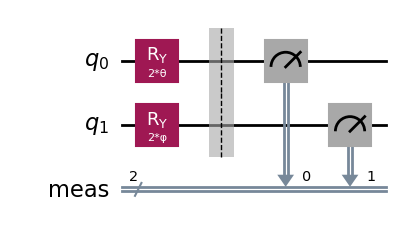

In [ ]:
theta = Parameter("θ")
phi = Parameter("φ")
qc = QuantumCircuit(2)
qc.ry(2 * theta, 0)
qc.ry(2 * phi, 1)
qc.measure_all()
qc.draw("mpl")

In this example the system Hamiltonian will be defined as $H = Z_0 \otimes I + I \otimes Z_1$ where $ Z_0 $ and $ Z_1 $ are the Pauli-Z operators acting on qubits 0 and 1, respectively.

### 3.2.2 Create the observables

The `iterate_expectation` function requires a list of observables to estimate the observation values of the circuit. Like `estimate_expectation` you can build these observables using a list of Pauli strings. 

In [ ]:
observables = [("ZI", 1), ("IZ", 1)]

### 3.2.3 Submit the `iterate_expectation` job

When using the `iterate_expectation` function you can compute the observables $Z_0 \otimes I$ and $I \otimes Z_1$ directly from the variational circuit execution. Then you can add them to obtain the Hamiltonian and minimize it. 

In [ ]:
# Define the backend (replace "desired_backend" with your backend)
backend_name = "desired_backend"


def expectation_value(parameters):
    parameters_dict = {param.name: val for param, val in zip(qc.parameters, parameters)}
    job = fo.iterate_expectation(
        circuits=[qasm3.dumps(qc)],
        shot_count=1024,
        credentials=credentials,
        backend_name=backend_name,
        parameters=[parameters_dict],
        observables=observables,
    )
    return np.sum(job.result()["expectation_values"])

In [ ]:
from scipy.optimize import minimize

# Optimize θ and φ to minimize expectation value
result = minimize(
    expectation_value,
    x0=[np.pi / 4, np.pi / 4],
    bounds=[(0, np.pi), (0, np.pi)],
    method="COBYLA",
)

# Stop iterating after all circuits are sent
fo.stop_iterate(credentials, backend_name)

# Print results
print(f"Optimal θ: {result.x[0]:.4f}, Optimal φ: {result.x[1]:.4f}")
print(f"Minimum expectation value: {result.fun:.4f}")

Optimal θ: 1.5978, Optimal φ: 1.5127
Minimum expectation value: -2.0000


## 4. Running hybrid quantum-classical optimization jobs with `solve_qaoa`
Fire Opal's `solve_qaoa` function invokes a fully-packaged [QAOA solver](https://docs.q-ctrl.com/fire-opal/execute/run-algorithms/solve-optimization-problems/fire-opals-qaoa-solver), which automates all aspects of the Quantum Approximate Optimization Algorithm (QAOA) algorithm and optimizes each component for hardware execution.

Fire Opal repeatedly submits a quantum job and then uses a classical optimizer to optimize the set of inputs for the next quantum job. The algorithm continues this iteration process until convergence is reached.

The following example demonstrates the process of submitting a simple `solve_qaoa` job, which will run multiple quantum jobs with your chosen hardware provider. See how you can [solve Max-Cut problems at full device](https://docs.q-ctrl.com/fire-opal/apply/solve-max-cut-using-fire-opal) scale using Fire Opal's QAOA solver, or [define a custom cost function](https://docs.q-ctrl.com/fire-opal/execute/run-algorithms/solve-optimization-problems/how-to-define-a-qaoa-cost-function) to solve any type of binary optimization problem.

### 4.1 Generate the optimization problem graph
The QAOA solver accepts either a graph or a polynomial cost function as problem definition. This example leverages a graph-based problem definition, which also requires defining the `problem_type` parameter.

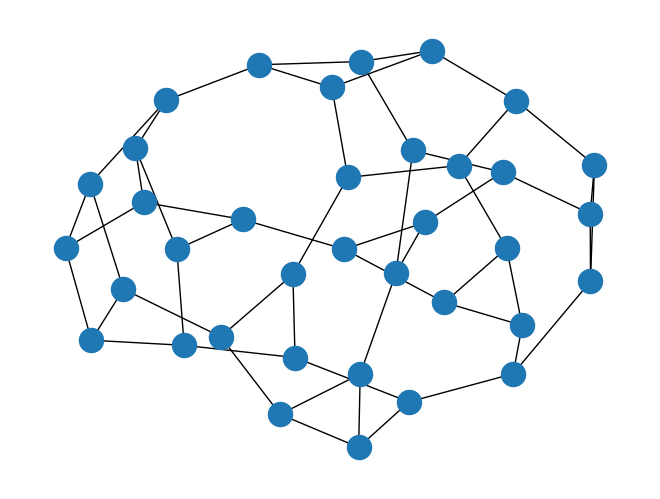

In [53]:
# Define a random unweighted graph
graph = nx.random_regular_graph(d=3, n=36, seed=8)
nx.draw(graph, nx.kamada_kawai_layout(graph))

### 4.2 Submit the job

In [54]:
# Define the backend (replace "desired_backend" with your backend)
backend_name = "desired_backend"

In [55]:
# Run the QAOA solver
fire_opal_job = fo.solve_qaoa(
    problem=graph,
    credentials=credentials,
    problem_type="maxcut",
    backend_name=backend_name,
)

This function performs multiple consecutive runs. Wait time may vary depending on hardware queues.



### 4.2 Check status and retrieve results
Since this function involves multiple quantum job executions, the results may be slightly delayed.

In [56]:
fire_opal_job.status()

{'status_message': 'Job has been submitted to Q-CTRL.',
 'action_status': 'STARTED'}

You can use the same function to retrieve results or error messages.

In [ ]:
results = fire_opal_job.result()

In [63]:
print(results["solution_bitstring"])
print(results["solution_bitstring_cost"])

000010011011000110011100101111111000
-48.0


## 5. Advanced runtime options

The [`run_options` parameter](https://docs.q-ctrl.com/references/fire-opal/fireopal/fireopal.run_options) allows you to specify additional hardware provider-specific configurations. For example, you can input job tags that will be surfaced on the provider platform for easier tracking and management. You can also pass a session ID, to leverage an existing [Qiskit Runtime Session](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.Session), which enables you to maintain your position in the device queue across jobs executed both with and without Fire Opal.

**_Note: `run_options` are currently only supported for the IBM Quantum Platform._** 

In [76]:
run_options = fo.run_options.IbmRunOptions(
    job_tags=["your_job_tag"], session_id="your_session_id"
)

fire_opal_job = fo.execute(
    circuits=[qasm3.dumps(qc)],
    shot_count=shot_count,
    credentials=credentials,
    backend_name=backend_name,
    run_options=run_options,
)

In [1]:
from fireopal import print_package_versions

print_package_versions()

| Package               | Version |
| --------------------- | ------- |
| Python                | 3.12.9  |
| networkx              | 2.8.8   |
| numpy                 | 1.26.4  |
| sympy                 | 1.12.1  |
| fire-opal             | 8.3.1   |
| qctrl-workflow-client | 5.3.1   |
